# Short Time Fourier Transform
The short time Fourier transform (STFT) is one of the most basic audio analysis algorithms, which is introduced in the following.

## Problem:
Assuming you have a signal $x(n)$ with increasing frequency over time (a so called sweep). A plot of the time domain signal in green has basically no information.

A plot of the magnitude spectrum in blue shows the frequency range of the signal. Unfortunately, you have no information, at which time step, which frequency is active.

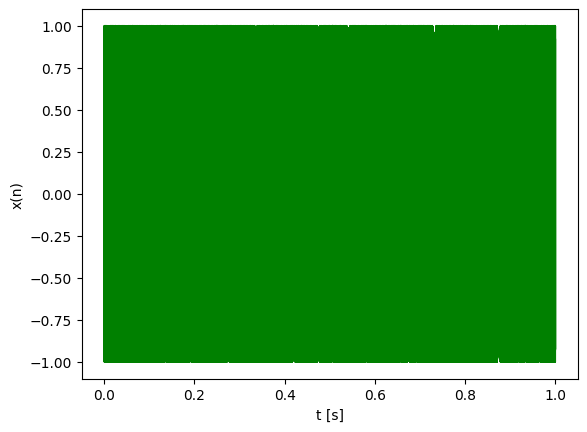

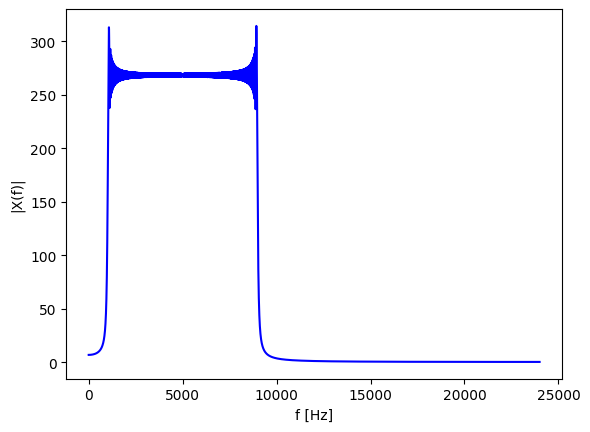

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Fs = 48000
t = np.arange(Fs) / Fs
f = (np.arange(Fs) / Fs) * 4000 + 1000
x = np.sin(2*np.pi*f*t)

plt.plot(t, x, 'g')
plt.xlabel('t [s]')
plt.ylabel('x(n)')
plt.show()

X = np.fft.fft(x)
NyquistIndex = int(X.shape[0]/2+1)
f_axis = np.arange(NyquistIndex)/X.shape[0]*Fs
X = np.abs(X[0:NyquistIndex])
plt.plot(f_axis, X, 'b')
plt.xlabel('f [Hz]')
plt.ylabel('|X(f)|')
plt.show()

## Solution
A local analysis of the signal would exhibit the local signal properties (dominant frequencies) and their evolution over time.

The algorithm for this local analysis is the STFT.

As a first step, an analysis window $w(n)$ is defined. In this sample, a Hann window is used.

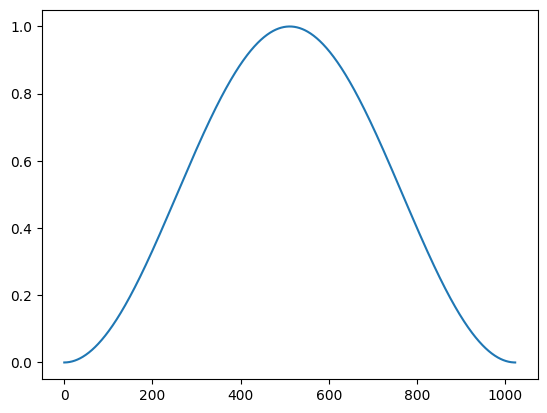

In [2]:
def HannWindow(N):
    return 0.5*(1-np.cos(2*np.pi*(np.arange(N) + 0.5)/N)) # analysis window

ws = 2**10 # window size
hs = int(ws/2) # hop size
w = HannWindow(ws)

plt.plot(w)
plt.show()

The result of the STFT is a so called spectrogram. Its evaluation is explained in the following:

The analysis window is mulitplied with the first samples of the signal. The product is analysed by the DFT. The resulting spectrum is stored in the first column of the spectrogram.

The analysis window is moved by the so called hop size. Again the corresponding region of the signal is multiplied with the analysis window, the DFT is applied and the resulting spectrum is stored in the second column of the spectrogram.

Repeat this algorithm until enough samples of the input signal are analysed.

This algorithm is shown in the following. The first three signal regions are plotted after multipication with the window function.

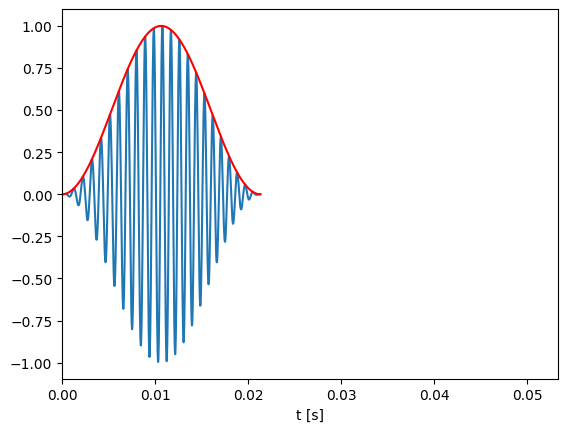

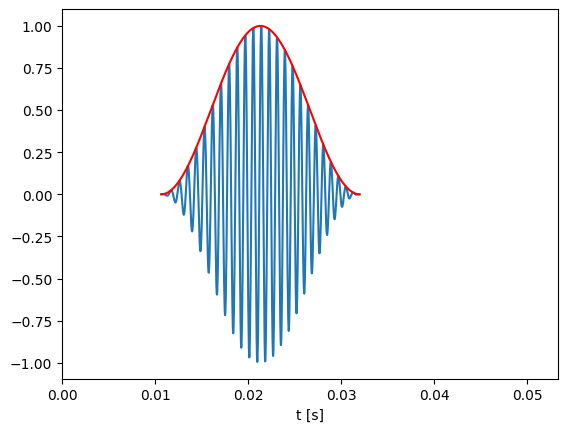

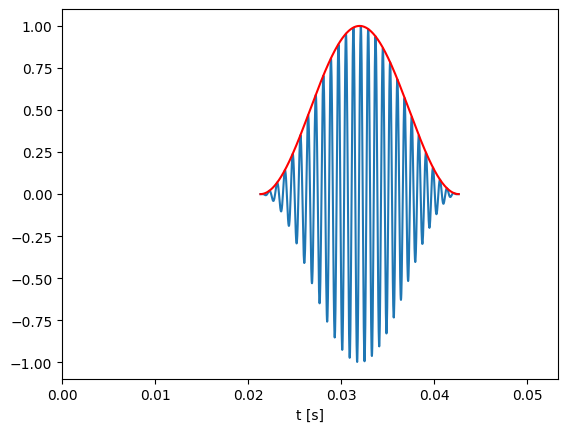

In [3]:
K = 2*ws # use zero padding with a factor of 2
NumberOfColumns = int((x.shape[0] - ws) / hs + 1)
NyquistIndex = K // 2 + 1
X = np.zeros((NyquistIndex, NumberOfColumns), dtype = complex)
for column in range(NumberOfColumns):
    idx1 = column * hs
    idx2 = idx1 + ws
    LocalTimeSignal = x[idx1:idx2] * w
    LocalSpectrum = np.fft.fft(LocalTimeSignal, n = K)
    X[:, column] = LocalSpectrum[0:NyquistIndex]
    
    # the following code has nothing to do with the STFT and is for visualization purposes only
    MaxColumnForVisualization = 3
    if column < MaxColumnForVisualization:
        t = np.arange(idx1, idx2) / Fs
        plt.plot(t, LocalTimeSignal)
        plt.plot(t, w, 'r')
        plt.xlabel('t [s]')
        plt.xlim(0, (MaxColumnForVisualization * hs + ws) / Fs)
        plt.show()

The resulting matrix or the so called spectrogram is plotted in the folowing. The lower magnitudes in the spectra has a dark colour. The higher magnitudes has a lighter colour. The dominant frequencies are plotted as a colourmap or as a landscape.

The plotted spectrogram in this example shows the increasing frequency over time.

The second plot shows the first five columns of the spectrogram plotted in different colours in order to show the correspondencies between the plot of the whol spectrogram and the plot of single columns.

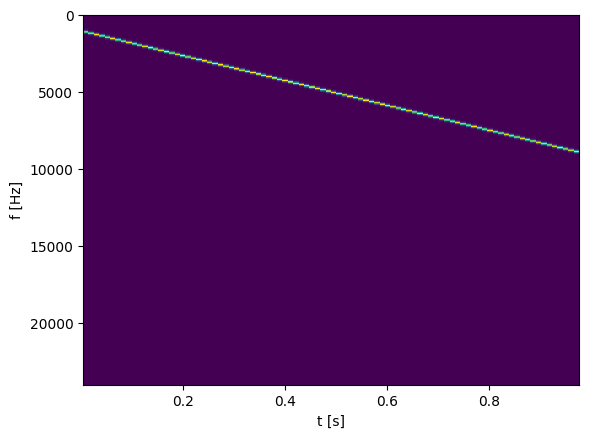

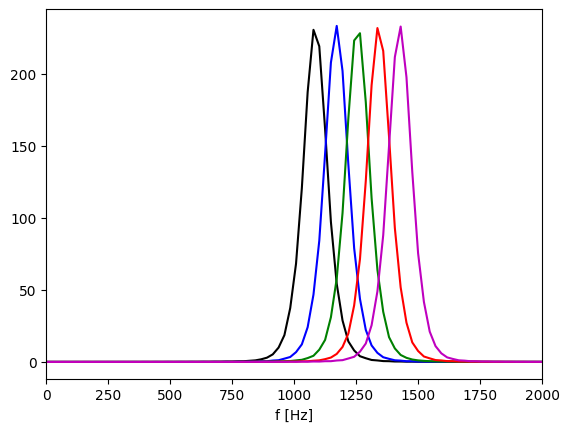

In [11]:
def PlotSpectrogram(X, t, f, PlotSingleColumns = False):
    plt.imshow(X, interpolation='nearest',aspect='auto', extent =[t.min(), t.max(), f.max(), f.min()])
    plt.xlabel('t [s]')
    plt.ylabel('f [Hz]')
    plt.show()

    if PlotSingleColumns:
        f_vector = np.arange(X.shape[0])*Fs/K
        colorvector = 'kbgrm'
        for column in range(len(colorvector)):
            plt.plot(f_vector, X[:, column], colorvector[column])
        plt.xlim(0, 2000)
        plt.xlabel('f [Hz]')
        plt.show()

Delta_f = Fs / K
Delta_t = hs / Fs
f = np.arange(X.shape[0]) * Delta_f
t = np.arange(X.shape[1]) * Delta_t + Delta_t/2
PlotSpectrogram(np.abs(X), t, f, PlotSingleColumns = True)

## Constant overlap add property
In the following experiment it is checked, for which combinations of windowsize and hopsize the Hann window has the constant overlap add property necessary for signal analysis and synthesis:

In [12]:
def CheckOverlapAdd(w, OverlapInPercent):
    ws = w.shape[0]
    hs = int((1 - OverlapInPercent / 100) * ws)
    NumberOfAnalysisWindows = 10
    WindowSum = np.zeros((NumberOfAnalysisWindows-1)*hs+ws)
    for n in range(NumberOfAnalysisWindows):
        idx1 = n*hs
        idx2 = idx1 + ws
        WindowSum[idx1:idx2] += w
    MiddlePartOfWindowSum = WindowSum[ws:-ws]
    assert np.std(MiddlePartOfWindowSum) < 1e-3, 'no constant window sum beside fade in and fade out effects'

CheckOverlapAdd(HannWindow(1024), 50)
CheckOverlapAdd(HannWindow(1024), 75)

## Time-Frequency Resolution
In the above shown example a signal with continuous signal properties is analysed by the STFT: a sweep.

In the following a signal with two short noisy bursts and two sinusses is assumed.

The two bursts are very close to each other: $10$ milliseconds. Therefore, they can only be separately analysed in a spectrogram with short analysis windows, e.g. $480$ samples for windowsize.

The two sinusses have similar frequencies: $4001$ Hz and $4211$ Hz. They can only be separately analysed in a spectrogram with long analysis windows which results in a good frequency resolution $\Delta_f$, e.g. a windowsize of $9600$ samples.

These both conditions, good time resolution for a windowsize of $480$ samples and good frequency resolution for a windowsize of $9600$ samples cannot be fullfilled at the same time. Therefore, short analysis windows lead to a good time resolution, which allows to separate the two noisy bursts. On the other hand, long analysis windows lead to a good frequency resolution, which allows to separate the two sinusses. In this case, the two bursts are not distinguishable in the spectrogram.

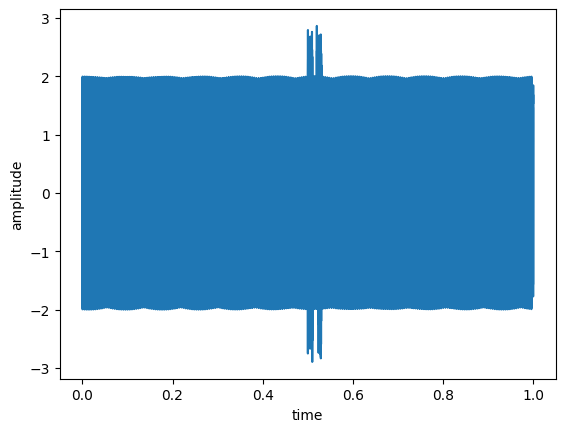

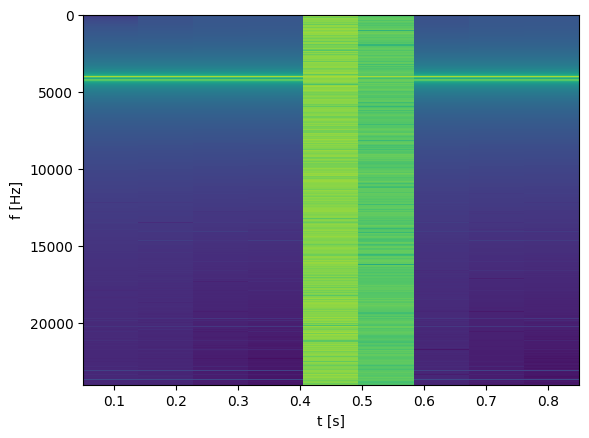

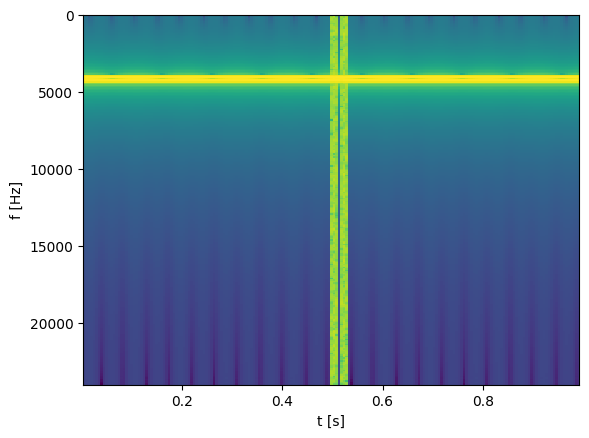

In [16]:
t = np.arange(Fs)/Fs
x = np.zeros(t.shape)
# add two sinusses with the given frequencies
for f in [4001, 4211]:
    phi = f**2 # arbitrary phase
    x += np.sin(2*np.pi*f*t + phi)

# add two short noisy bursts
BurstLengthInMilliseconds = 10
BurstLengthInSamples = int(BurstLengthInMilliseconds * Fs / 1000)
for n in range(2):
    idx1 = int(t.shape[0]/2 + 2*n*BurstLengthInSamples)
    idx2 = idx1 + BurstLengthInSamples
    x[idx1:idx2] += np.random.rand(BurstLengthInSamples)*2-1

plt.plot(t, x)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

def Spectrogram(x, WindowSize, FFTLen = None, HopSize = None):
    if HopSize is None:
        HopSize = WindowSize // 2 # 50 % of overlap
    if FFTLen is None:
        FFTLen = WindowSize
    NumberOfColumns = int(np.floor((x.shape[0] - WindowSize) / HopSize) + 1)
    X = np.zeros((FFTLen // 2 + 1, NumberOfColumns), dtype = complex)
    w = HannWindow(WindowSize)
    for column in range(NumberOfColumns):
        idx1 = column * HopSize
        idx2 = idx1 + WindowSize
        x_Block = x[idx1:idx2] * w
        X[:, column] = np.fft.rfft(x_Block, n = FFTLen)
    return X

K = 9600
hs = K // 2
X_9600 = Spectrogram(x, K, K, hs)
Delta_f = Fs / K
Delta_t = hs / Fs
f = np.arange(X_9600.shape[0]) * Delta_f
t = np.arange(X_9600.shape[1]) * Delta_t + Delta_t/2
PlotSpectrogram(20*np.log10(np.abs(X_9600)), t, f)

K = 480
hs = K // 2
X_480 = Spectrogram(x, K, K, hs)
Delta_f = Fs / K
Delta_t = hs / Fs
f = np.arange(X_480.shape[0]) * Delta_f
t = np.arange(X_480.shape[1]) * Delta_t + Delta_t/2
PlotSpectrogram(20*np.log10(np.abs(X_480)), t, f)

## Time resolution of the human ear

The hearing cells in the human ear can fire roughly once per millisecond. By this, the hopsize of the human ear can be approximated by this value.

## Programming exercise
The inverse short time Fourier transform works with the overlap add algorithm:

Each column of the spectrogram is transformed into time domain by the inverse DFT. This local time domain signal $y_\text{block}$ is moved to the position corresponding to this column of the spectrogram. At this position, $y_\text{block}$ is added up into the output signal $y$.

If the window functions used for analyses add up to the constant $1$, there is no error between input signal $x$ and output signal $y$. Therefore, it is important to know, at which combinations of windowsize and hopsize the analysis windows add up to a constant.

The length of the FFT (FFTLen) should be a power of $2$ at least if you are evaluating the FFT on a low cost processor. Implement the procedure NetPowerOf2, which finds a integer value, which is a power of two and which is greater or equal than WindowSize.

Implement the procedure ISTFT.

In [22]:
def NextPowerOf2(WindowSize):
    FFTLen = 0
    FFTLen = int(2**np.ceil(np.log2(WindowSize))) # solution
    return FFTLen

def ISTFT(X, WindowSize = None, HopSize = None):
    y = 0
    ### solution
    FFTLen = (X.shape[0] - 1) * 2
    if WindowSize is None:
        WindowSize = FFTLen
    if HopSize is None:
        HopSize = WindowSize // 2
    
    y = np.zeros(((X.shape[1] - 1) * HopSize + WindowSize))
    for column in range(X.shape[1]):
        idx1 = column * HopSize
        idx2 = idx1 + WindowSize
        y_block = np.fft.irfft(X[:, column], n = FFTLen)
        y[idx1:idx2] += y_block[:WindowSize]
    y *= 2 * HopSize / WindowSize
    ### solution
    return y
        
import unittest

class TestProgrammingExercise(unittest.TestCase):

    def test_PowerOf2(self):
        x = np.random.randint(100) + 1
        y = NextPowerOf2(x)
        z = np.log2(y)
        self.assertGreaterEqual(1e-10, 2**z - y)
        self.assertGreaterEqual(y, x)
    
    def test_ISTFTOutputLength(self):
        ws = 1000
        hs = ws // 2
        FFTLen = ws
        x = np.random.randn(50000)
        X = Spectrogram(x, ws, FFTLen, hs)
        y = ISTFT(X)      
        self.assertEqual(x.shape[0], y.shape[0])

    def test_ISTFT(self):
        ws = 1000
        hs = ws // 2
        FFTLen = ws
        x = np.random.randn(50000)
        X = Spectrogram(x, ws, FFTLen, hs)
        y = ISTFT(X)
        x = x[:y.shape[0]]
        Offset = ws - hs
        x = x[Offset:-Offset]
        y = y[Offset:-Offset]       
        self.assertGreater(10*np.log10(np.sum(x**2) / np.sum((x-y)**2)), 200)

    def test_ISTFT_hs(self):
        hs = 500
        ws = hs * (np.random.randint(4) + 2)
        FFTLen = ws
        x = np.random.randn(50000)
        X = Spectrogram(x, ws, FFTLen, hs)
        y = ISTFT(X, ws, hs)
        x = x[:y.shape[0]]
        Offset = ws - hs
        x = x[Offset:-Offset]
        y = y[Offset:-Offset]
        a = np.sum(x*y)/np.sum(y**2)
        self.assertGreater(10*np.log10(np.sum(x**2) / np.sum((x-a*y)**2)), 200)

    def test_ISTFT_FFTLen(self):
        hs = 500
        ws = hs * (np.random.randint(4) + 2)
        FFTLen = NextPowerOf2(ws + np.random.randint(ws))
        x = np.random.randn(50000)
        X = Spectrogram(x, ws, FFTLen, hs)
        y = ISTFT(X, ws, hs)
        x = x[:y.shape[0]]
        Offset = ws - hs
        x = x[Offset:-Offset]
        y = y[Offset:-Offset]
        a = np.sum(x*y)/np.sum(y**2)
        self.assertGreater(10*np.log10(np.sum(x**2) / np.sum((x-a*y)**2)), 200)

    def test_ISTFT_CorrectScaling(self):
        hs = 500
        ws = hs * (np.random.randint(4) + 2)
        FFTLen = NextPowerOf2(ws + np.random.randint(ws))
        x = np.random.randn(50000)
        X = Spectrogram(x, ws, FFTLen, hs)
        y = ISTFT(X, ws, hs)
        x = x[:y.shape[0]]
        Offset = ws - hs
        x = x[Offset:-Offset]
        y = y[Offset:-Offset]
        self.assertGreater(10*np.log10(np.sum(x**2) / np.sum((x-y)**2)), 200)
    
unittest.main(argv=[''], verbosity=2, exit=False)

test_ISTFT (__main__.TestProgrammingExercise.test_ISTFT) ... ok
test_ISTFTOutputLength (__main__.TestProgrammingExercise.test_ISTFTOutputLength) ... ok
test_ISTFT_CorrectScaling (__main__.TestProgrammingExercise.test_ISTFT_CorrectScaling) ... ok
test_ISTFT_FFTLen (__main__.TestProgrammingExercise.test_ISTFT_FFTLen) ... ok
test_ISTFT_hs (__main__.TestProgrammingExercise.test_ISTFT_hs) ... ok
test_PowerOf2 (__main__.TestProgrammingExercise.test_PowerOf2) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.081s

OK


## Exam preparation

1) An audio signal of length $3$ seconds has a sampling rate of $r=16$ kHz. The frequency resolution $\Delta f$ should be better than $10$ Hz. The time resolution should be better than $50$ spectra per second. The overlap of two neighbouring windows is $50$ \%. Evaluate the minimum values of $K$ and $N$. Is zero padding necessary? Evaluate the memory consumption of this spectrogram, if each real valued parameter needs 4 Bytes and each complex valued parameter needs 8 Bytes of memory.

2) According to the above plotted spectrograms, which statement is true: The smaller the windowsize, the better the time resolution of a spectrogram. The greater the windowsize, the better the time resolution of a spectrogram.

3) According to the above plotted spectrograms, which statement is true: The smaller the windowsize, the better the frequency resolution of a spectrogram. The greater the windowsize, the better the frequency resolution of a spectrogram.

4) An audio signal of length $5$ seconds is analysed by a STFT. The windowsize / blocksize is $N=100$ ms. The overlap is $75$ %. How many blocks are analysed?

5) An audio signal of length $5$ seconds is analysed by a STFT. The hopsize corresponds to the time resolution of the human ear.  The spectra are transformed to the frequency resolution of the human ear. The frequency range, stored in the spectrogram is $0\leq b \leq 24$ Bark. How many values are stored in the spectrogram?

6) A window function is defined by $w(n)=\left(0.5-0.5\cdot\cos\left(2\pi\frac{n+0.5}{N}\right)\right)^\alpha$ with $0\leq n<N$ and $0\leq\alpha$. Which hopsize leads to a constant overlap add independent from the parameter $\alpha$? For which $\alpha$ $w(n)$ is euqal to the Hann window?